# Overall view 

1. Read the graph and store in adjancey list.
    - the text file is adjancacey list seperated by space with first line the number of vertices
2.  Read the motif as adjancey matrix 
    - the text file is edge list with first line number of vertices, type of motif and motf count
    - don't know what type motif means 
    
3. Clique core decompose, core decompose but instead of degree use motif degree ``CDSdecompose.decompose``
    -  Count all k -cliques of graph to get the motif degree of each vertex. Here K is user definded ``KList.ListFast``
    - peeling algorithm to determine the k - clique core values of all verticies
    - return motif data 

        5 columns, n + 1 rows, 
        - columns 0 : vertex removed in step i (index) of peeling algotithm. I.e verticies in ascending order of clique core value
        - column 1 : motif degree of vertex before deletion.
        - column 2 : average motif density of graph after removing the vertex
        - column 3 : Total motifs in graph after removing the vertex 
        - column 4 : core value of the removed vertex

        - row 0 : no vertex is stores rest data is of graph before no - vertex is removed 
        - row 1 : first vertex removed and the rest data 
        - and so on 

4. Locate the k - $\psi$ clique core from the graph, k is definded as the lower bound ``LocateCore.locate``
    -   Based of each core, average motif density, select the core with maximum average motif density and set that core values as the lower bound 
    - remove verticies that are not part of k - $\psi$ clique core 
    - create new graph, new motif data
    - return 
        - new graph, new graph size, 
        - lower bound (core value), 
        - index of deleted vertex in motif records (before which all verticies were removed)
        - num of deleted motifs, 
        - average motif density of current graph, 
        - maximum clique core value.  
5. List all k-cliques and update the clique core values in the new graph returned in step 4. ``KList.ListRecords``
    - Returns 
    - same motif data structure 
    - motif statiscis - map of all cliques.  key is string and value is array of verticies in clique plus 1 representing motif count e.g '0-1-2' $\rightarrow$ (0, 1, 2, 1)

6. Remove edges that are not part of any clique ``InvalidEdgePruning.Prune``
    - returns 
        -   the new graph that only includes the edges that are part of any clique
        -   number of removed edges  

7. Locates all the connected components in the new graph (step 6). ``ComponentDecom.decompose``
    - Performs BFS to find all the connected components
    - returns 
        - Queue of all the connected components
        - each object in queue contains information 
            - new graph (connected component)
            - new graph size
            - new motif data
            - total motifs in component 
            - average motif density of conponent
            - motif degree of each vertex
8. Run the core exact algorithm to find the density subgraph is all the connected components. ``DynamicExactalgo.DynamicExact``
    - returns 
        -   max average motif density
        -   motif number 
        -   total vertex 
        -   connected component  





# Details of each Function 

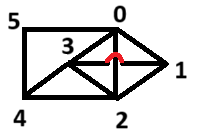

## CDSdecompose.decompose (step 3)

1. Count all k - cliques in the graph to get the motif degree of each vertex. ``KList.ListFast``
    - motif degree = [3, 3, 4, 4, 1, 0]
2.  intialize data structure to store the motif data (described in step 3 of overall)
3.  Create a bin of all motif degrees. that is index i $\rightarrow$ numer of verrices with motif degree i. 
    - motif bin  = [1, 1, 0, 2, 2, 0]

4. Do a cumulaive prefix sum of the bin arrays 
    - cumilative sum = new bin = [0, 1, 2, 2, 4, 6]
5. Sort in accesing order kinda like bucket sort
   - vert: stores the verticies by motif degree ascending order
   - pos: sorts the position of vertx in storted array

   algo:
    1. iter through the vertex: 
    2. set pos[v] = bin[motifDegree[v]]
    3. vert[pos[v]] = v 
    4. bin[motifDegree[v]] += 1

    | Vertex | Motif Degree | Bin | Position | Vert | Bin Array       | Pos Array       | Vert Array       |
    |--------|--------------|-----|----------|------|-----------------|-----------------|------------------|
    |    0   |      3       |  2  | 0 --> 2  |2 --> 0| [0, 1, 2, 3, 4, 6]    | [2, -, -, -, -, -]   | [-, -, 0, -, -, -]    |
    |    1   |      3       |  3  | 1 --> 3  | 3-->1 | [0, 1, 2, 4, 4, 6]    | [2, 3, -, -, -, -]   | [-, -, 0, 1, -, -]    |
    |    2   |      4       |  4  | 2 --> 4  |4 -->2 | [0, 1, 2, 4, 5, 6]    | [2, 3, 4, -, -, -]   | [-, -, 0, 1, 2, -]    |
    |    3   |      4       |  5  | 3 -->5   |5 -->3 | [0, 1, 2, 4, 6, 6]    | [2, 3, 4, 5, -, -]   | [-, -, 0, 1, 2, 3]    |
    |    4   |      1       |  1  | 4 -->1   |1 -->4 | [0, 2, 2, 4, 6, 6]    | [2, 3, 4, 5, 1, -]   | [-, 4, 0, 1, 2, 3]    |
    |    5   |      0       |  0  | 5 -->0   |0 -->5 | [1, 2, 2, 4, 6, 6]    | [2, 3, 4, 5, 1, 0]   | [5, 4, 0, 1, 2, 3]    |

6. Peeling clique core decomposition 

    Algo
    1. Iter through vertex $v$
    2. find index of the vertex with minimum motif degree
    3. Extract neighborhood arround the vertex $v$ which is at max 2 hops away, and get the motif degree of the verticies in neighborhood (motif degree only because of cliques that include the vertex $v$ ) ``Generate``
    return
        -  maps of vertex $\rightarrow$ motif degree
        - count of verticies removed
    4. iter through the map (step3):
        1. increament the deleted motif count $count_{dm}$
        2. decrease the motif degree of the vertex
    5. decrease motif count by $count_{dm}$ in motif data at row $v+1$
    6. update the average motif density in motif data row number vertex removed $v+1$ as vertex and motif count changed 

    | step   | vertex min degree | motif degree | neighborhood | Cliques include vertex | motif degree of neighborhood | updated motif degree | motif count | motif Density | core value | 
    |--------|--|--|----------|------|---------------|---------------|----------------|---------------|----------------|
    |    0   |      -       |  -  | -  |-| - | [3,3,4,4,1,0] | 5 | 5/6  | - |
    |    1   |      5       |  0  | [5,0,4,3,2,1]  | - | [0,0,0,0,0,0]  | [3,3,4,4,1,0] | 5| 5/5 | 0 |
    |    2   |      4       |  1  | [4,2,3,0,1]  | [(4,2,3)] | [0,0,1,1,1,0] | [3,3,3,3,0,0]| 4 |4/4| 1|
    |    3   |      0       |  3  | [0,1,2,3]|[(0,2,3),(0,1,2),(0,1,3)]| [3,2,2,2,-,-] | [0,1,1,1,0,0] | 3 | 1/3 | 3 |
    |    4   |      1       |  3  | [1,2,3]   | [(1,2,3)] | [0,1,1,1,-,-] | [0,0,0,0,0,0] | 0 | 0/2   | 3 |
    |    5   |      2       |  3  | [2,3]   | - | [-,0,0,-,-,-] | [0,0,0,0,0,0] | 0 | 0/1   | 3 |
    |    6   |      3       |  3  | -  | - | [-,-,0,-,-,-] | [0,0,0,0,0,0] | 0 | 0   | 3 |


    


## LocateCore.locate (step 4)


1. Based on the maximum density we found the in step 1 of peeling algo ``CDSdecompose.decompose`` motif data, we have max core density 1, so lower bound $l = \lceil \text{max core density} \rceil = 1$
2. delete all vertex with clique core value below than lower bound removed vertex = [5]
3. new graph 
    |vertex| neighbors|
    |-----|--------|
    |0| [1, 2, 3] |
    |1| [0, 2, 3] |
    |2| [0, 1, 3, 4]|
    |3| [0, 1, 2, 4] |   
    |4| [2, 3]|

5. $density = 1, \text{graph size} = 4, \text{lower bound} = 1, \text{upper bouund} = max(core) = 3, \text{deleted motif } = 0, \text{deleted index} = 1$

## KList.ListRecords (step 5)

1.  Apply core decompose to normal core values of verticies, sorted verticies array based on the core values, order of vertex in sorted array (starts with 1 instead of zero).
core values = [3, 3, 4, 4, 1, 0]
verticies sorted by core value = [2, 3, 0, 1, 4, 5]
order = [3, 4, 1, 2, 5, 6]

2. Generate a Directed Acyclic graph.
    - Edges will go only forward from lower order to higher order

    Algo
    1. create new adjancey list to store the DAG. 
    1. intr through the vertices $v$, 
    2. Count neighbors of $v$ whose order is > order of $v$
    3. create new neighbor list of size count. 
    4. push neighbors of $v$ whose order is > order of $v$

    |vertex| old neighbors | count | new neighbors |
    |----|----|----|----|
    |0 | [1, 2, 3, 5] | 2 |  [1, 5] |
    |1 | [0, 2, 3] | 0 | [] |
    | 2 | [0, 1, 3, 4] | 4 | [0, 1, 3, 4] |
    | 3| [0, 1, 2, 4] | 3 |[0, 1, 4] | 
    | 4 | [2, 3, 5] | 1 | [5] |
    | 5 | [0, 4] | 2 | [] |

    The DAG is

   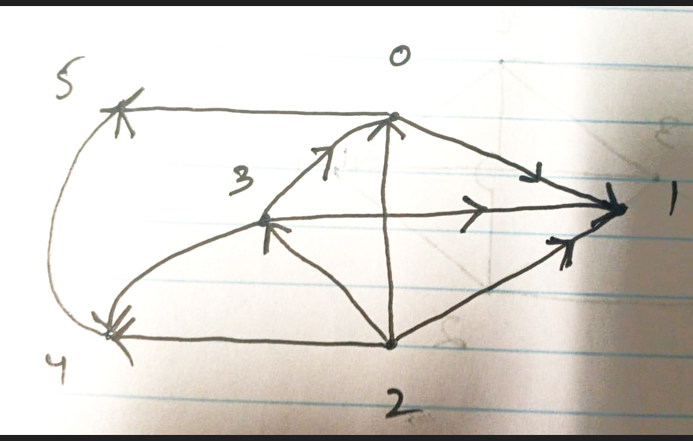


   3. List all k - cliques. K is user defined 
      - returns
        - Statistics HashMap of String and Array i.e if we have a 3  -clique 0,1,2 then hashmap will have key "0 1 2": value [0,1,2]
        - Motif degree of all verticies 

    Algorithm :

    Parameters K, C - stores partail cliques,  Arr - stores candiadte set, Label array of size equal to graph size.
    1. Intailize C to emtpy, Arr to all verticies in Graph and Label to K
    2. if (k > 2)
        1. iter through all the verticies $v$ in candidate $Arr$
        2. Get neighbors of vertex $v$ whose label is K, set label of neighbor to $k-1$. This marks verticies are processed in this level.  Lets call them valid neighbors and store in array $arr_n$. 
        3. Iter through valid neighbors $n_v$
            1. iter through neighbors $n_{n_V}$ of $n_v$ 
            2. reorder the neighbors of $n_v$ to put valid ones (label == k - 1 )at start. and non valid at end. 
            3. update the degree of $n_{n_v}$ to number of valid neighbors. 
        4. Add $v$ to $C$ 
        5. run recurcively on $k-1, C, $arr_n$$
        5. Remove $v$ fron $C$
        6. Update label arrays to $K$
    3. if (k==2)
        1. Intialize string $key$ to empty string, and motif count to 0.
        2. Add values in C to string key, eg C = [1, 2], key = "1 2".
        3. Iter through $v_c$  all candidate sets $Arr$ .
        4. iter through valid neighbors $n_{v_c}$of $v_c$.
            1. new key = key + " " + $n_{v_c}$
            2. increase motif degree of $n_{v_c}$. 
            3. increament motif degree of $v_c$.
            4. Intialize array to store clique $clique$ of size $k+1$.
            5. add partail clique to the array
            6. $clique[k-2] = v_{c}$
            7. $clique[k-1] = n_{v_c}$
            6. $clique[k] =1$ means the clique is completed
            7. add new key and clique to stastistics
        5. for all verticies in partail clique 
            1. increase motif degree by count


$k = 3$, $C= []$ $arr=[0,1,2,3,4,5]$,  $degree = [2, 0, 4 , 3, 1, 2]$

**Note:** the degree here is degree in DAG

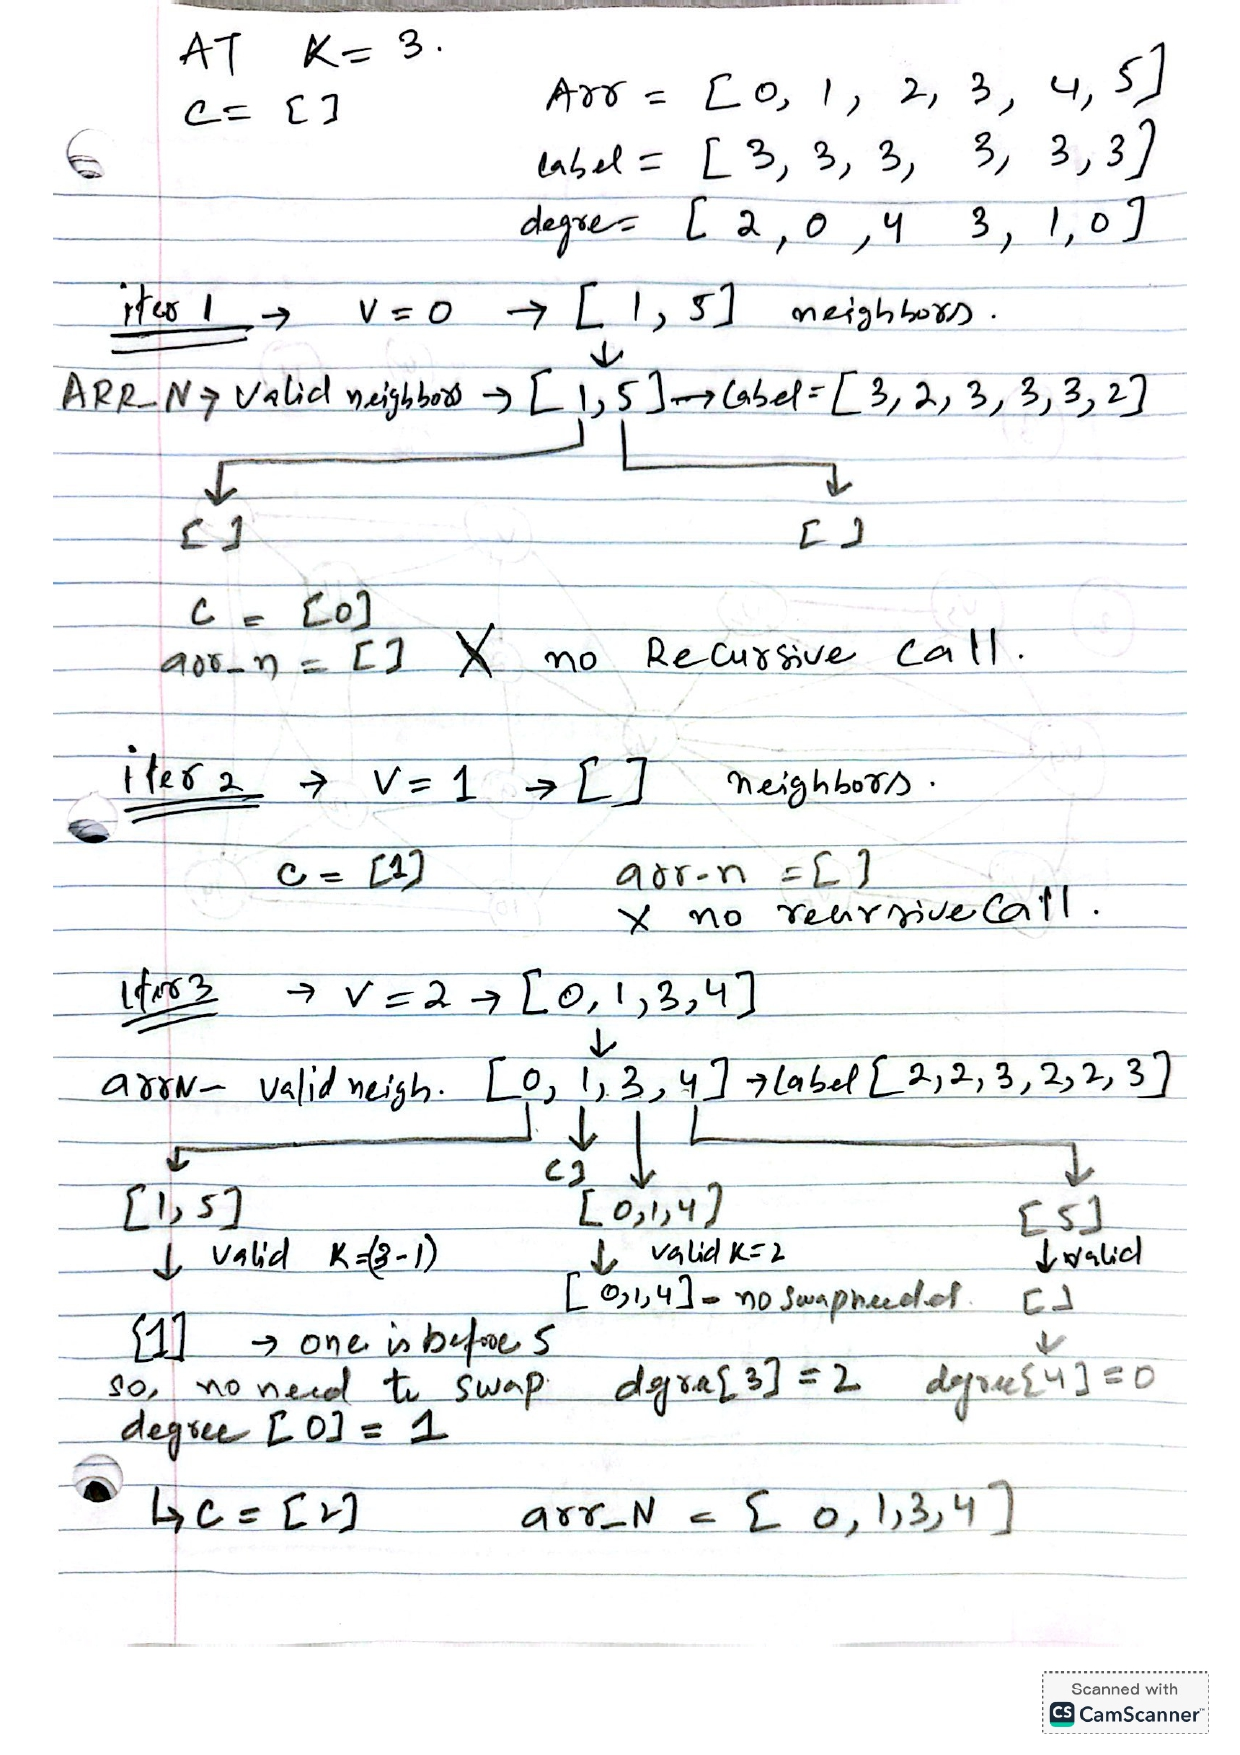
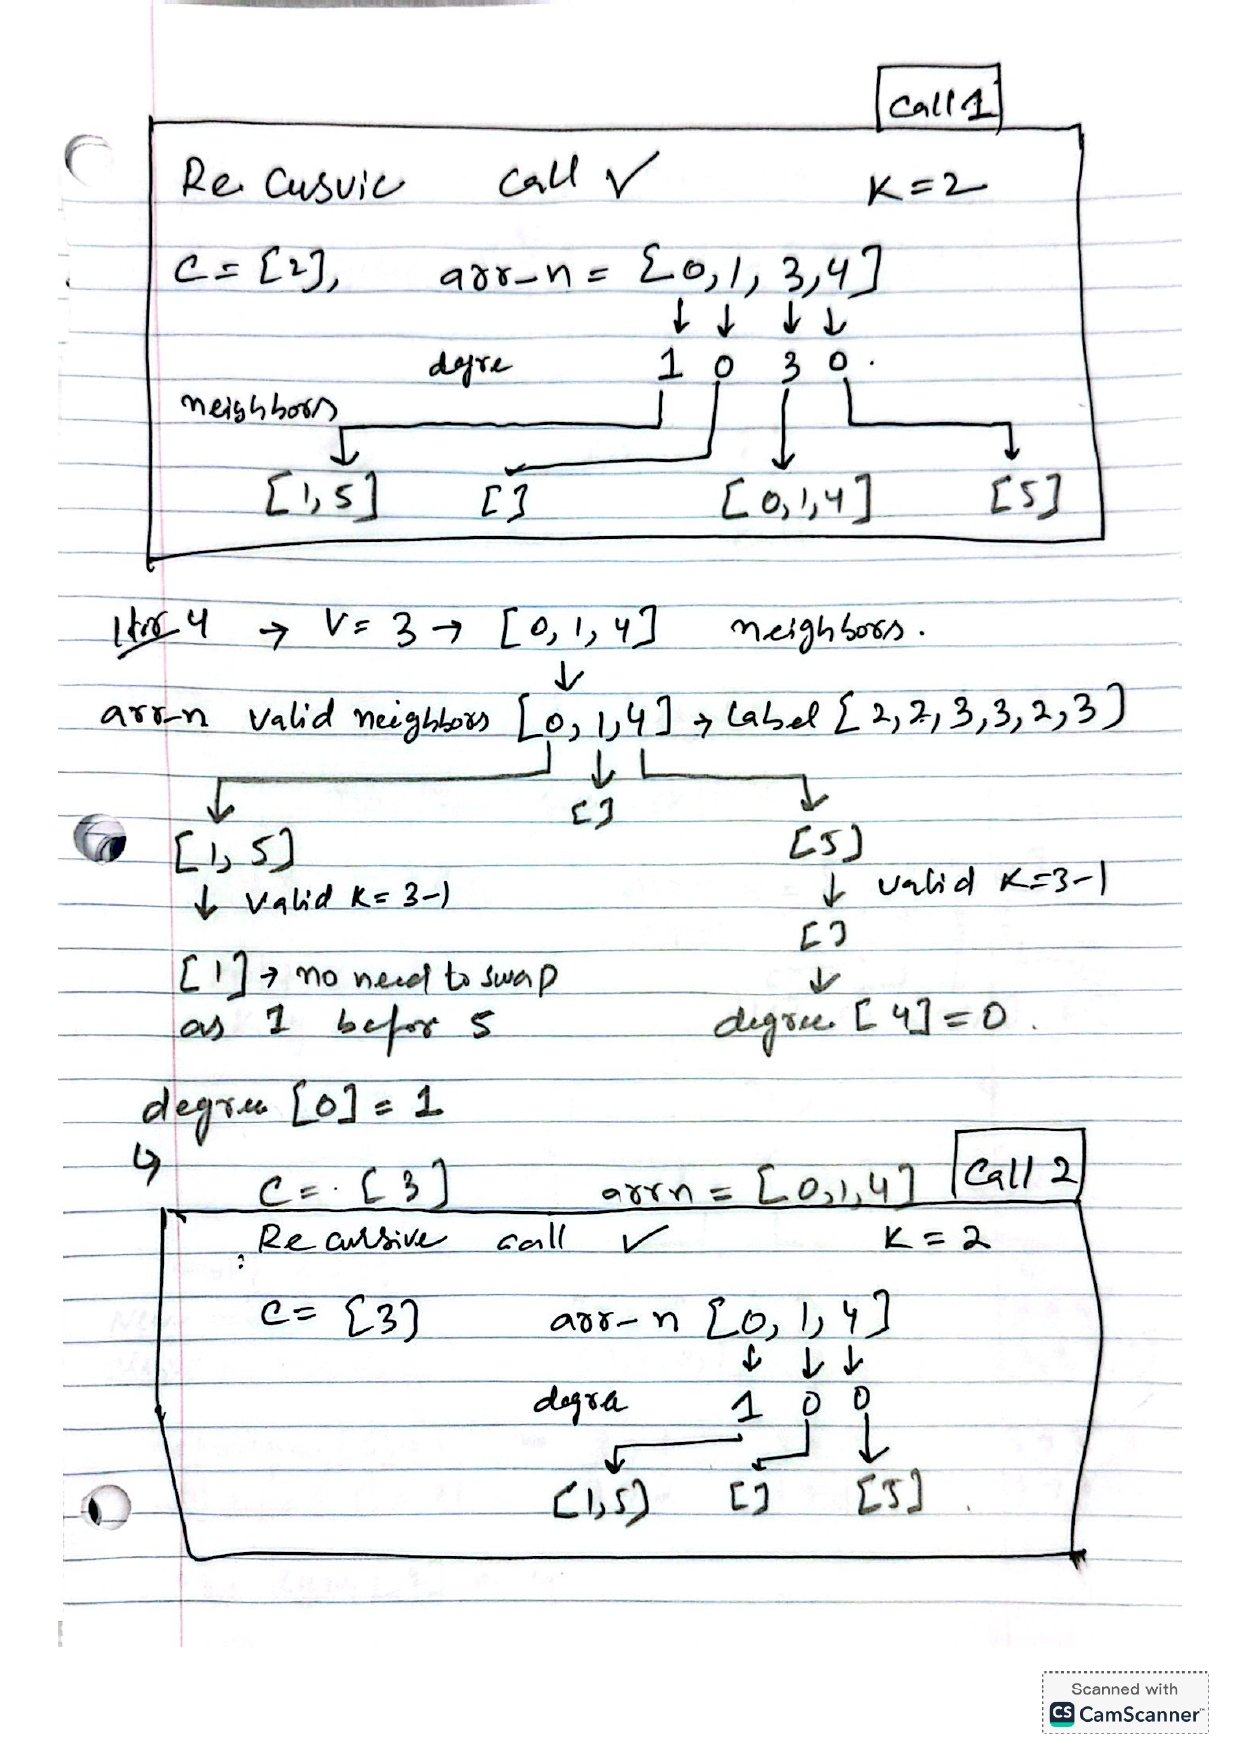
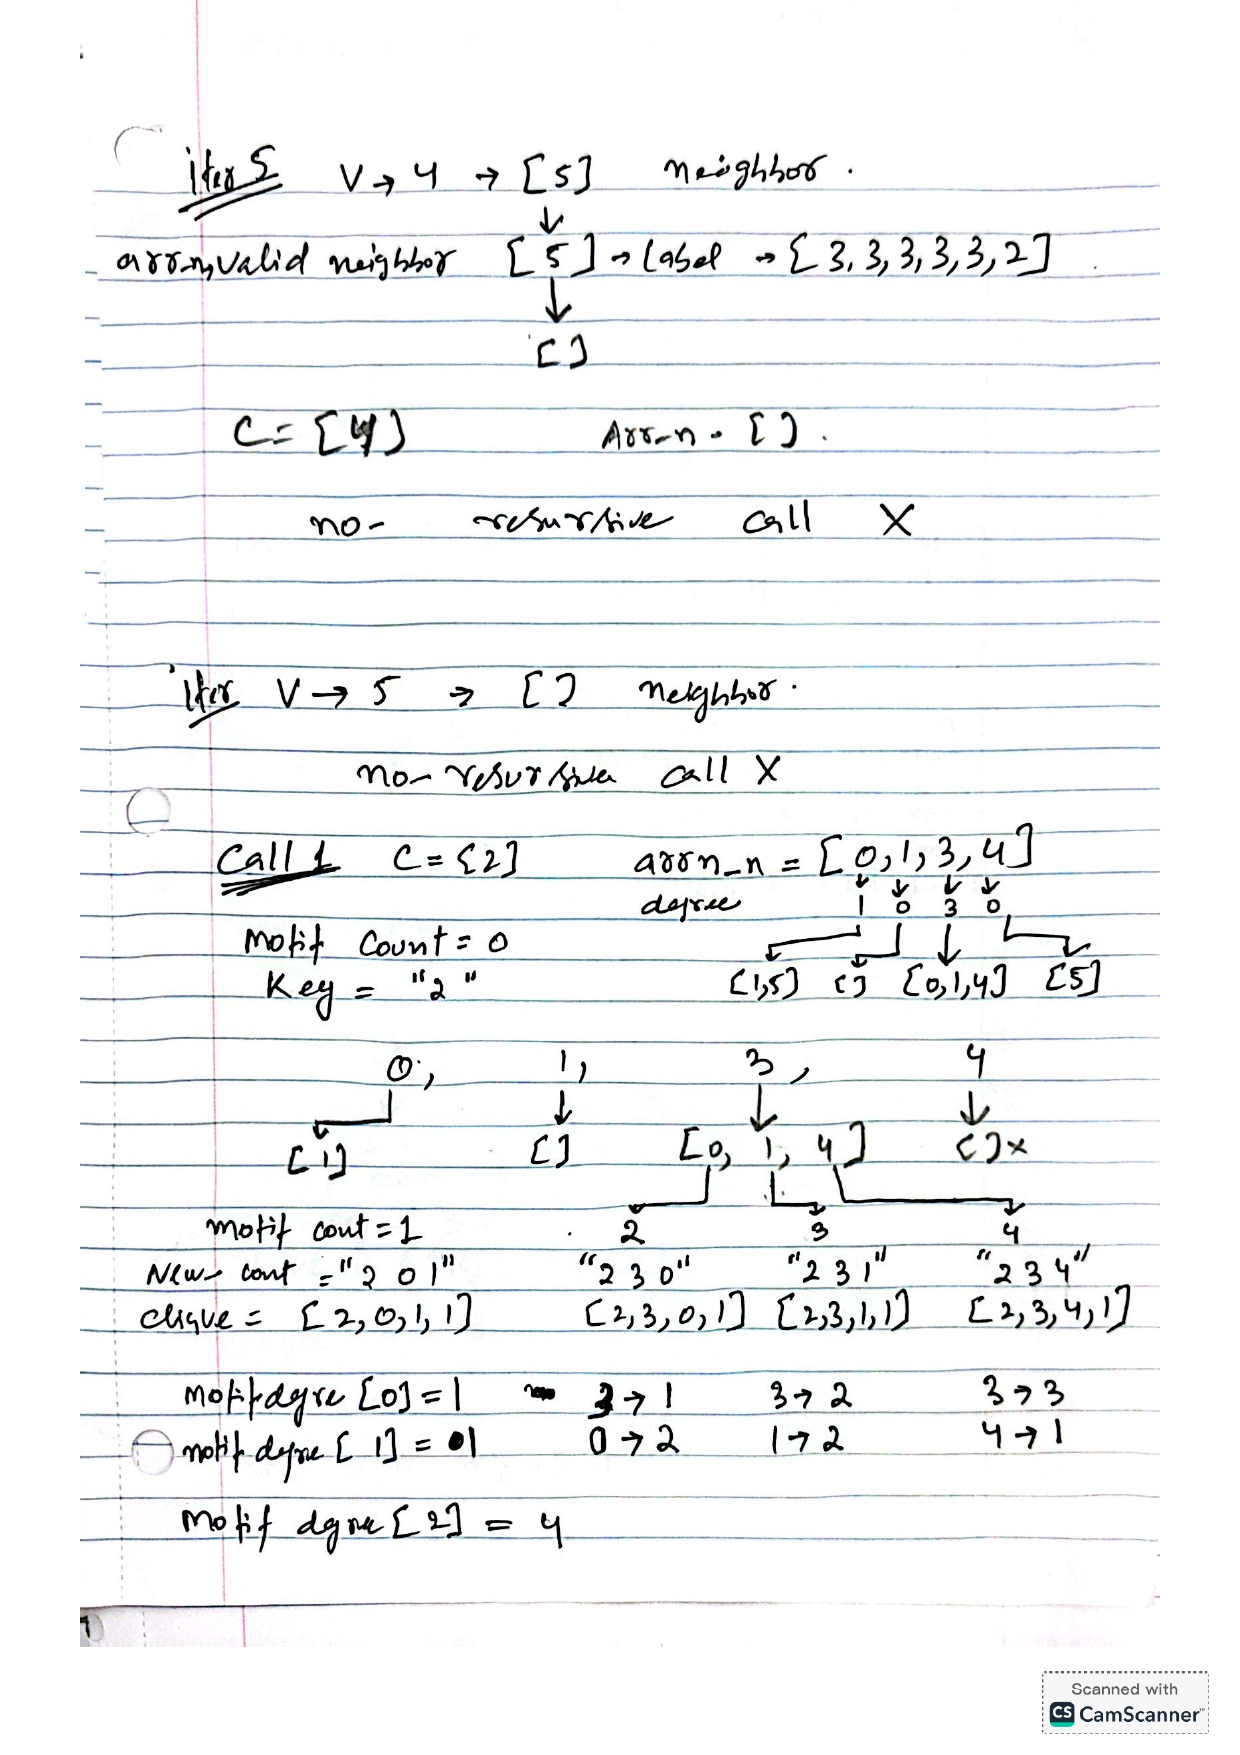
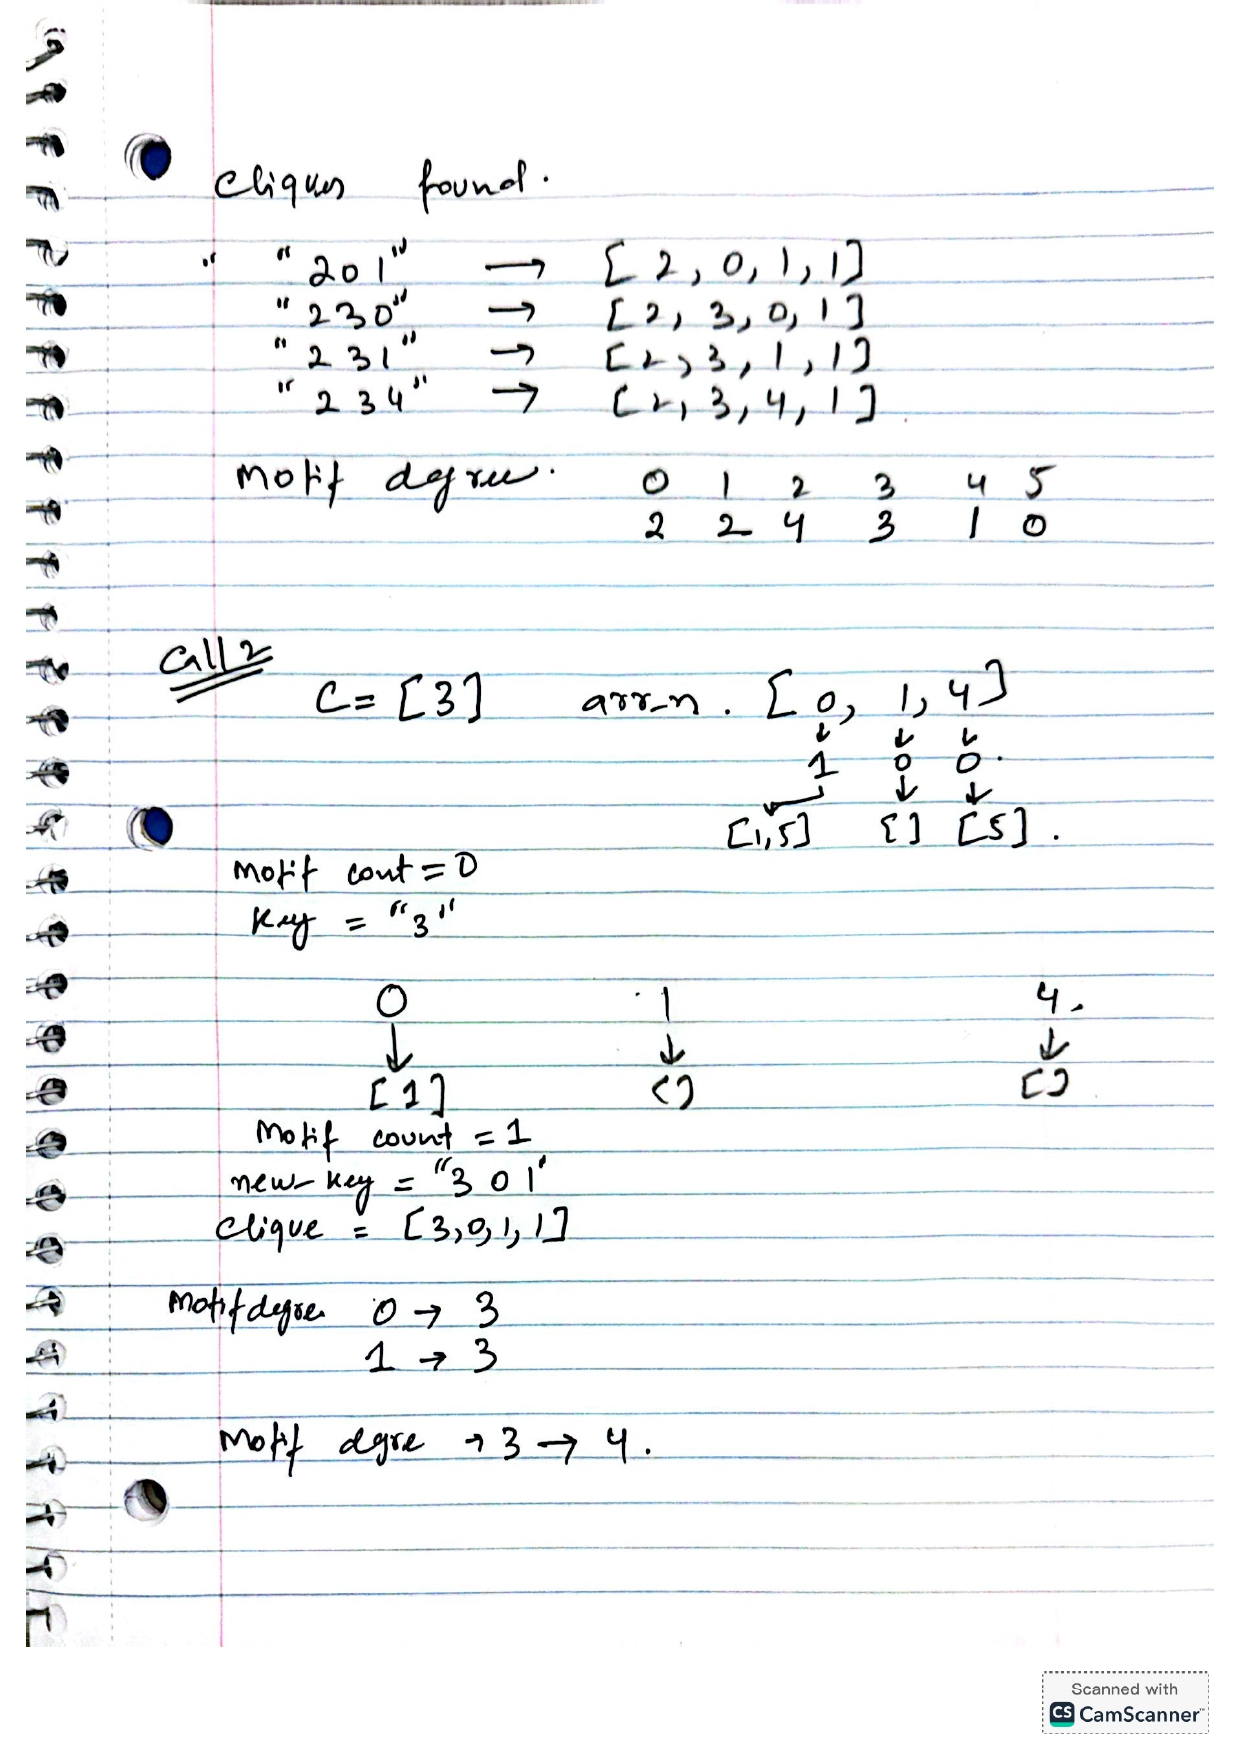

## InvalidEdgePruning.Prune (Step 6)

1.  Remove the edges that are not part of any motif 
    return: 
    - new graph with edges that are part of atleast on motif 
    - count of removed edges

    Example :

   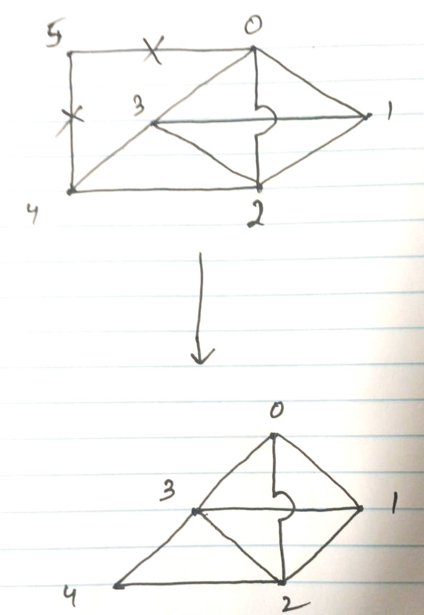

## ComponentDecom.decompose (step 7)

1. Perform BFS to find all connected components
2. Create a queue to store the connected components
3. For each connected component, create new graph mappings, create a new motif data for connected component
4. Get motif degree of each vertex in connected component
 
 Return:
    - Queue


## DynamicExactalgo.DynamicExact (step 8)

1. Iter through all connected components to get the lower bound. $\text{lower bound} = \text{max}_{\text{component} \in \text{Queue}} \{ \text{motif density}_{component} \}$
2. set upper bound to $Kmax$
3. set DSD = null and max density = 0
4. Iter through connected component
    1. Run ``Exactalgo.Exact`` on conncted component with lower bound and upper bound
    2. Canculate the motif count in the subgraph returned by step 3.1
    3. Count verticies in new subgraph 
    4. if (current density > max density)
        1. update DSD and max density 

Return:
- DSD
- Max motif density

### Exactalgo.Exact

1. set guess density = (lower bound + upper bound)/2
2. stopping condition = 1/ (graph size )*(graph size -1)
3. construct the flow network
    1. Construct a map (flow network) of size graph size + clique size + 2 (for source and sink)
    2. At each index of flow network intialize of hashmap key: child value [capacity, available flow]
    3. for each clique $\psi$ in motif degree. 
        1. for each vertex $v$ in clique
            1. Add edge from motif to vertex with capacity and available flow $k-1$. 
            2. add edge from vertex to motif with capacity and available flow 1.
    4. for each vertex $v$ in graph.
        1. add edge from source to vertex with capacity and available flow of motif degree
        2. add edge from vertex to source with capacity and available flow 0
        3. add edge from vertex to sink with capacity and avaialble flow $\text{guess} \times \text{motif size}$
        4. add edge from sink ti vertex with capacity and available flow 0.
4. set result subgraph = []
4. while (upper bound - lower bound ) > stopping condition
    1. set min cut (maximum posible flow through an augmented path ) to infinity
    2. get augmented path and mim cut. 
        1. total flow = 0
        2. while(min cut != -1)
            1. update the available flow in forward edges by decreasing available flow by min cut
            2. update the available flow in backward edges by increasing the flow by min cut.
            3. increase total flow by min cut
            4. get new augmented path and mim cut.
    3. if total flow == motif count X motif size, i.e $S = \{s\}$
        1. Upper bound = guess
    4. else, i.e $S \neq \{s\}$
        1. Lower bound = guess
    5. guess = (lower bound + upper bound)/2
    6. Reconstruct the flow netwrok with new capacity and guess changed. 